# Question 1 Analysis

In this question we were curious, whether it would be possible to predict the range of a vehicle based in Washington D.C. based on its characteristics, such as the **year**, **CAFV eligibility**, **Electric Vehicle Type**, **Electric Utility**, as well as the **make** of the car.

Created by mikayelg@stanford.edu

## Part 1: Data Gathering and Filtering

Importing the necessary libraries for working with our data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

Loading the dataset from the URL of the official U.S. government website at https://catalog.data.gov/dataset/electric-vehicle-population-data.

In [2]:
DATA_URL = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"

df = pd.read_csv(DATA_URL)
df_raw = df.copy() # Keeping an additional reference to the original dataset

Understanding what type of data we are dealing with.

In [3]:
df.head(2)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,2T3YL4DV0E,King,Bellevue,WA,98005.0,2014,TOYOTA,RAV4,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,103.0,0.0,41.0,186450183,POINT (-122.1621 47.64441),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
1,5YJ3E1EB6K,King,Bothell,WA,98011.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,1.0,478093654,POINT (-122.20563 47.76144),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10


Analyzing the unique values for columns that seemingly are categorical. More information about what information individual rows contain can be found at https://data.wa.gov/Transportation/Electric-Vehicle-Population-Data/f6w7-q2d2/about_data.

In [4]:
df['Electric Vehicle Type'].value_counts()

,count
Electric Vehicle Type,
Battery Electric Vehicle (BEV),184054
Plug-in Hybrid Electric Vehicle (PHEV),48176


Additionally, we have another categorical variable called `Clean Alternative Fuel Vehicle (CAFV) Eligibility`, which might be useful for constructing our models.

In [5]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

,count
Clean Alternative Fuel Vehicle (CAFV) Eligibility,
Eligibility unknown as battery range has not been researched,136865
Clean Alternative Fuel Vehicle Eligible,72847
Not eligible due to low battery range,22518


We can further simplify these values and assign simpler values to them.

In [6]:
df.loc[:, 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].map({
     'Clean Alternative Fuel Vehicle Eligible': 'YES',
     'Not eligible due to low battery range': 'NO',
     'Eligibility unknown as battery range has not been researched': 'UNKNOWN'
})

In [7]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

,count
Clean Alternative Fuel Vehicle (CAFV) Eligibility,
UNKNOWN,136865
YES,72847
NO,22518


From here, we only want to keep only the values which are strict meaning, either YES or NO.

In [8]:
df = df[df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] != 'UNKNOWN']
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

,count
Clean Alternative Fuel Vehicle (CAFV) Eligibility,
YES,72847
NO,22518


Only keeping the columns that we will be working with and deleting the rest.

In [9]:
del df['VIN (1-10)']
del df['County']
del df['City']
del df['DOL Vehicle ID']
del df['Postal Code']
del df['2020 Census Tract']
del df['Vehicle Location']
del df['Legislative District']
del df['State']
del df['Make']
del df['Model']
del df['Electric Utility']

Additionally, we are renaming the column `Model Year` to `Year`, `Electric Range` to `Range` and `Base MSRP` to `MSRP`.

In [10]:
df.rename(columns={
    'Model Year': 'Year',
    'Electric Range': 'Range',
    'Base MSRP': 'MSRP'
}, inplace=True)

<ipython-input-10-0c63b7f3a5ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


In [11]:
df.head()

,Year,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Range,MSRP
0,2014,Battery Electric Vehicle (BEV),YES,103.0,0.0
1,2019,Battery Electric Vehicle (BEV),YES,220.0,0.0
2,2025,Plug-in Hybrid Electric Vehicle (PHEV),YES,40.0,0.0
3,2024,Plug-in Hybrid Electric Vehicle (PHEV),YES,42.0,0.0
5,2016,Battery Electric Vehicle (BEV),YES,84.0,0.0


Additionally, we can get rid of all the NaN range variables from the data frame.

In [12]:
df = df[~df['Range'].isna()]

After all the filtering is done, we can calculate the number of records we have left. In the process of filtering, we lost more than 50% of the records from the total 194K that we had.

In [13]:
len(df)

95338

Additionally, we are interested in seeing what part of our dataset contains the original MSRPs of the cars.

In [14]:
len(df[~df['MSRP'].isna() & (df['MSRP'] > 0)])

3277

We have a pretty good chunk of ~3K vehicles that have information about their MSRP, which gives us some additional information in order to try and predict the ranges of potential electric vehicles. I want to keep this dataset for further analysis just in case we need it.

In [15]:
# This data includes only the rows where the cars have MSRPs listed
df_msrps = df[~df['MSRP'].isna() & (df['MSRP'] > 0)]
df_msrps.sample(5)

,Year,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Range,MSRP
129188,2018,Plug-in Hybrid Electric Vehicle (PHEV),NO,16.0,52650.0
129235,2018,Plug-in Hybrid Electric Vehicle (PHEV),NO,14.0,45600.0
79808,2014,Battery Electric Vehicle (BEV),YES,208.0,69900.0
119316,2019,Plug-in Hybrid Electric Vehicle (PHEV),NO,17.0,34995.0
148329,2018,Plug-in Hybrid Electric Vehicle (PHEV),NO,14.0,54950.0


And to make it easier to work with our data, I will reorder the columns.

In [16]:
df = df[['Year', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Range', 'MSRP']]
df.head()

,Year,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Range,MSRP
0,2014,Battery Electric Vehicle (BEV),YES,103.0,0.0
1,2019,Battery Electric Vehicle (BEV),YES,220.0,0.0
2,2025,Plug-in Hybrid Electric Vehicle (PHEV),YES,40.0,0.0
3,2024,Plug-in Hybrid Electric Vehicle (PHEV),YES,42.0,0.0
5,2016,Battery Electric Vehicle (BEV),YES,84.0,0.0


## Part 2 - Exploratory Data Analysis

For this part, I wanted to understand whether there are any correlations between the parts of my data. In particular, I was interested in finding out whether there are correlations between the `Range` of a given vehicle, and any of the given parameters:
*   `Year`
*   `Model`
*   `Electric Vehicle Type`
*   `Clean Alternative Fuel Vehicle (CAFV) Eligibility`
*   `Electric Utility`
*   `MSRP` (separately)

Since we want to analyze purely electric vehicles, we would filter out only EVs with EV Types of BEV. Before doing so, let's understand the distribution of two vehicle types in Washington.

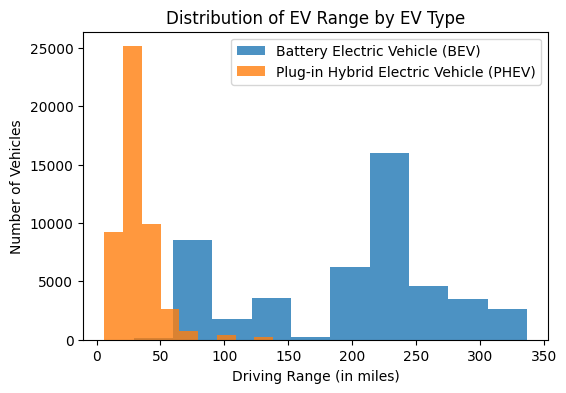

In [17]:
plt.figure(figsize=(6, 4))

for label, group in df.groupby('Electric Vehicle Type'):
  plt.hist(group['Range'], label=label, alpha=0.8)

plt.xlabel('Driving Range (in miles)')
plt.ylabel('Number of Vehicles')
plt.title('Distribution of EV Range by EV Type')
plt.legend()
plt.show()

In [18]:
df.groupby('Electric Vehicle Type')['Range'].median(),df.groupby('Electric Vehicle Type')['Range'].mean()

(Electric Vehicle Type
 Battery Electric Vehicle (BEV)            215.0
 Plug-in Hybrid Electric Vehicle (PHEV)     30.0
 Name: Range, dtype: float64,
 Electric Vehicle Type
 Battery Electric Vehicle (BEV)            198.223972
 Plug-in Hybrid Electric Vehicle (PHEV)     31.213359
 Name: Range, dtype: float64)

Additionally, let's analyze the distributions by years of both types.

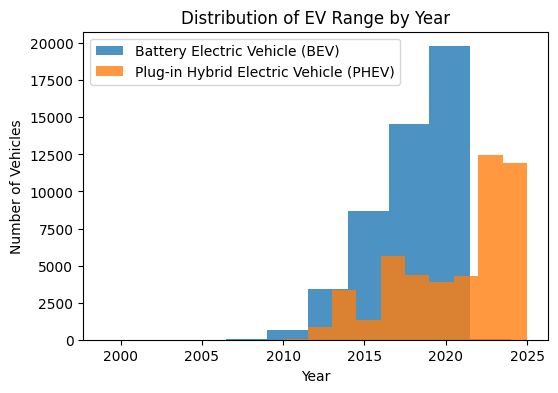

In [19]:
plt.figure(figsize=(6, 4))

for label, group in df.groupby('Electric Vehicle Type'):
  plt.hist(group['Year'], label=label, alpha=0.8)

plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.title('Distribution of EV Range by Year')
plt.legend()
plt.show()

In [20]:
df.groupby('Electric Vehicle Type')['Year'].mean()

,Year
Electric Vehicle Type,
Battery Electric Vehicle (BEV),2017.581682
Plug-in Hybrid Electric Vehicle (PHEV),2020.456645


From our data, it is evident that pure BEVs have a larger range than the ones which are plug-in hybrids. To verify this claim, let's check the correlations of the range and the year of the BEVs vs. PHEVs and understand them.

In [21]:
df[df['Electric Vehicle Type'].str.contains('BEV')]['Year'].corr(df['Range'])

0.7077494380109738

In [22]:
df[df['Electric Vehicle Type'].str.contains('PHEV')]['Year'].corr(df['Range'])

0.0078103019253122725

As we can see, the year of the car only matters when we are dealing with purely electric vehicles. For hybrids, there is a weak negative correlation, which suggests that the range of BHEVs is not really dependent on the year. It will become evident from the following graph that cars which are manufactured on later dates have a much better range.

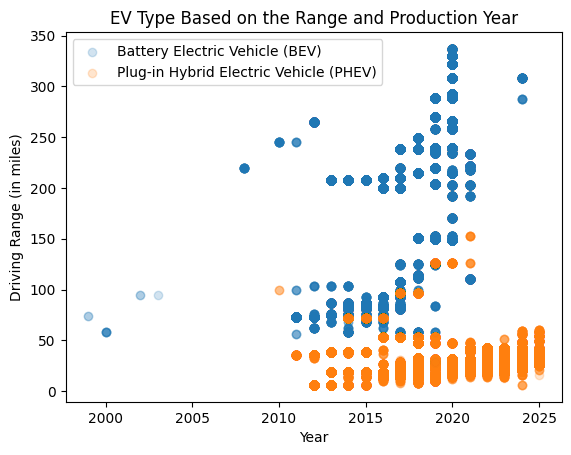

In [23]:
for name, group in df.groupby('Electric Vehicle Type'):
  plt.scatter(group['Year'], group['Range'], label=name, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Driving Range (in miles)')
plt.title('EV Type Based on the Range and Production Year')
plt.legend()
plt.show()

As we can see, there is a clearly increasing trend in the range in the number of registered vehicles by year.

Additionally, let's understand whether there is a correlation between the range and the CAFV Eligibility.

In [24]:
df[df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] =='YES']['Year'].corr(df['Range'])

-0.1680521492434662

In [25]:
df[df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] =='NO']['Year'].corr(df['Range'])

0.5135732767321028

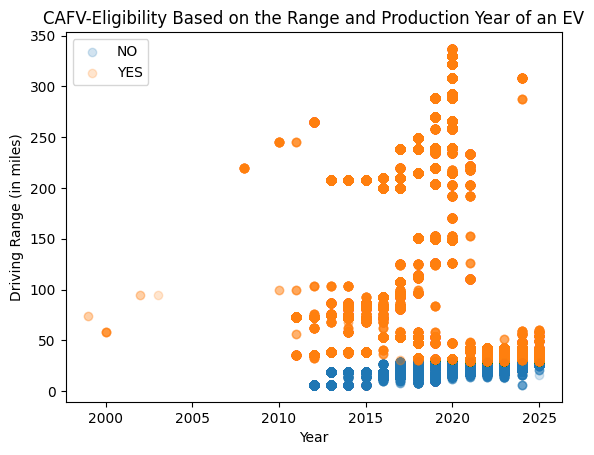

In [26]:
for name, group in df.groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility'):
  plt.scatter(group['Year'], group['Range'], label=name, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Driving Range (in miles)')
plt.title('CAFV-Eligibility Based on the Range and Production Year of an EV')
plt.legend()
plt.show()

Finally, let's see the number of vehicles from each category which are eligible and non-eligible for the CAEF specification as a bar graph.

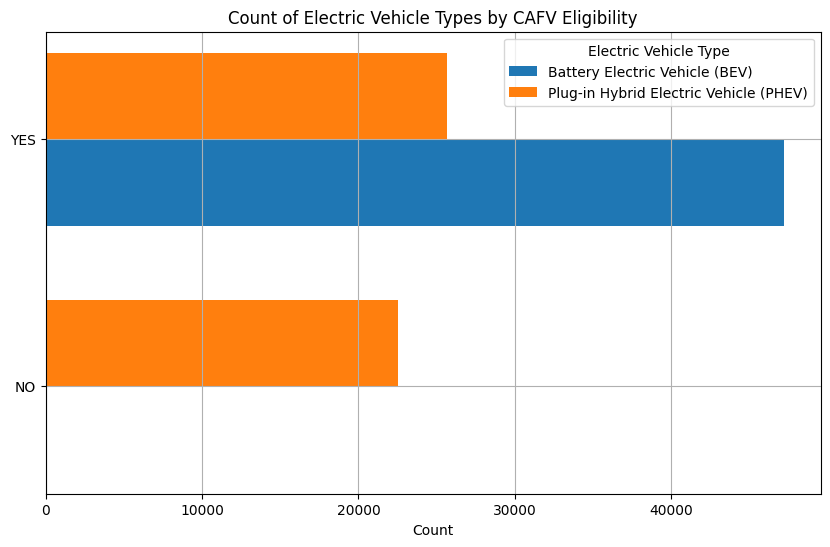

In [27]:
# Group by 'CAFV Eligibility' and 'Electric Vehicle Type' and count the occurrences
grouped = df.groupby(['Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Vehicle Type']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))

# Number of categories and bar width
n_categories = len(grouped.index)
bar_width = 0.35  # Width of each bar

# X locations for the groups
index = np.arange(n_categories)

# Plot each Electric Vehicle Type side by side
for i, ev_type in enumerate(grouped.columns):
    plt.barh(index + i * bar_width, grouped[ev_type], height=bar_width, label=ev_type)

# Customize the plot
plt.yticks(index + bar_width / 2, grouped.index)  # Position y-ticks in the middle of the group
plt.xlabel('Count')
plt.title('Count of Electric Vehicle Types by CAFV Eligibility')
plt.legend(title='Electric Vehicle Type')
plt.grid(True)

# Display the plot
plt.show()

## Part 3 - Implementation

In this part, I mainly focused on creating the Linear Regression and KNN Regression models, for training and validating the correctness of my predictors. To begin with, I started by training a Linear Regression model and validating the results based on the following types of independent fields, to predict the dependent field--`Range`.

### **Categorical**

*   `Electric Vehicle Type` - This distinguishes the vehicle as all electric or a plug-in hybrid.
*   `Clean Alternative Fuel Vehicle (CAFV) Eligibility` - This categorizes vehicle as Clean Alternative Fuel Vehicles (CAFVs) based on the fuel requirement and electric-only range requirement in House Bill 2042 as passed in the 2019 legislative session.

### **Numerical**

*   `Year` - The model year of the vehicle, determined by decoding the Vehicle Identification Number (VIN).

### Linear Regression Predictor

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

numerical = ['Year']
categorical = ['Electric Vehicle Type',
               'Clean Alternative Fuel Vehicle (CAFV) Eligibility']

X_train, X_test, y_train, y_test = train_test_split(
    df[numerical + categorical],
    df['Range'],
    test_size=0.4,
    random_state=999)

ct = make_column_transformer(
    (StandardScaler(), numerical),
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    remainder='passthrough',
)

pipeline = make_pipeline(ct, LinearRegression())
pipeline.fit(X_train, y_train)

mse = mean_squared_error(y_train, pipeline.predict(X_train))
rmse = np.sqrt(mse)

print("Training Accuracy")
print("-"*48)
print(f"RMSE: {rmse} | MSE: {mse}")

Training Accuracy
------------------------------------------------
RMSE: 48.01347681407699 | MSE: 2305.2939557759087


### Linear Regression Predictor - Measuring the **Training** Accuraccy

And to understand what accuracy our model has on real data, we can create train-test splits to accomplish that.

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions_test = pipeline.predict(X_test)

mse = mean_squared_error(y_test, predictions_test)
rmse = np.sqrt(mse)

print("Testing Accuracy")
print("-"*48)
print(f"RMSE: {rmse} | MSE: {mse}")

Testing Accuracy
------------------------------------------------
RMSE: 48.17966149720478 | MSE: 2321.279781985237


To visualize our testing predictions, let's create a plot.

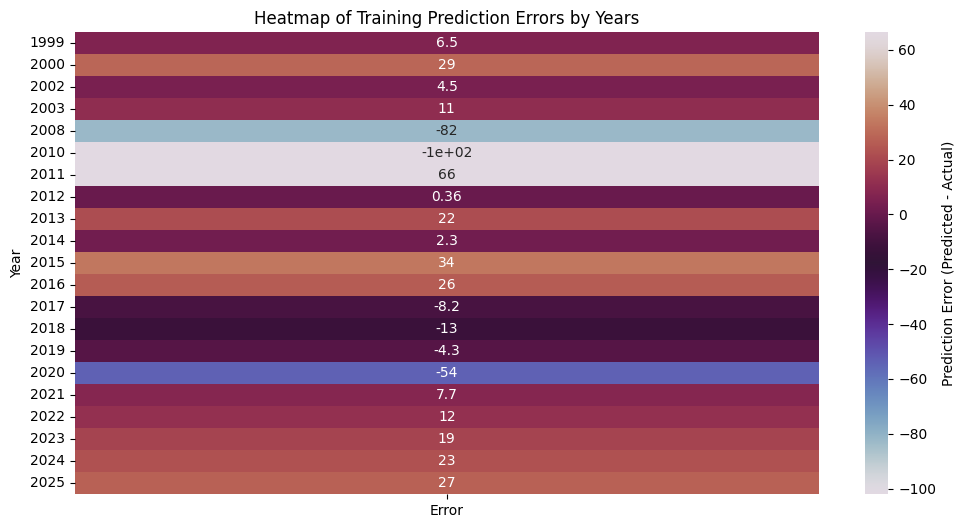

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_train_pred = pipeline.predict(X_train)

# Create the training results DataFrame
train_results = pd.DataFrame({
    'Year': X_train['Year'],
    'Actual': y_train,
    'Predicted': y_train_pred
})

# Calculate the mean actual and predicted values for each year
yearly_comparison = train_results.groupby('Year').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# Calculate the error (Predicted - Actual)
yearly_comparison['Error'] = yearly_comparison['Predicted'] - yearly_comparison['Actual']

# Set the 'Year' as the index for plotting
yearly_comparison.set_index('Year', inplace=True)

# Plot the heatmap using the 'Error' values
plt.figure(figsize=(12, 6))
sns.heatmap(yearly_comparison[['Error']],
             annot=True, cmap='twilight',
             cbar_kws={'label': 'Prediction Error (Predicted - Actual)'})
plt.title('Heatmap of Training Prediction Errors by Years')
plt.show()

### Linear Regression Predictor - Measuring the **Testing** Accuraccy

And if we actually wanted to compare both, training results and testing results, we could plot them separately.

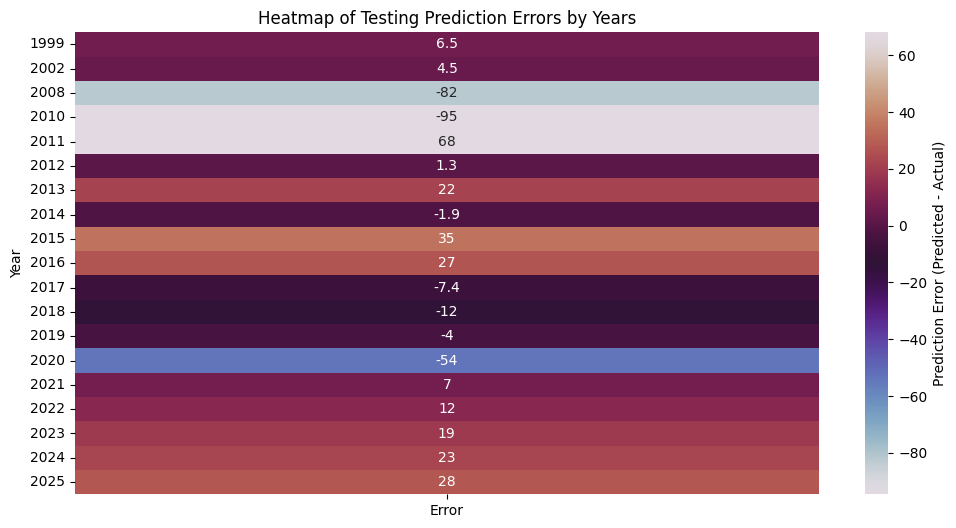

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_test_pred = pipeline.predict(X_test)

# Create the training results DataFrame
train_results = pd.DataFrame({
    'Year': X_test['Year'],
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Calculate the mean actual and predicted values for each year
yearly_comparison = train_results.groupby('Year').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# Calculate the error (Predicted - Actual)
yearly_comparison['Error'] = yearly_comparison['Predicted'] - yearly_comparison['Actual']

# Set the 'Year' as the index for plotting
yearly_comparison.set_index('Year', inplace=True)

# Plot the heatmap using the 'Error' values
plt.figure(figsize=(12, 6))
sns.heatmap(yearly_comparison[['Error']], annot=True, cmap='twilight',
             cbar_kws={'label': 'Prediction Error (Predicted - Actual)'})
plt.title('Heatmap of Testing Prediction Errors by Years')
plt.show()

### KNN Regression Predictor

Since our dataset contains thousands of records, it would make more sense to check 5 to 30 neighbors and see whether there are any fluctuations in the predictions. Additionally, we can try and measure the performance of our model using different metrics such as euclidean and manhattan distances.

In [32]:
len(df)

95338

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

numerical = ['Year']
categorical = ['Electric Vehicle Type',
               'Clean Alternative Fuel Vehicle (CAFV) Eligibility']
X_train = df[numerical + categorical]
y_train = df['Range']

ct = make_column_transformer(
    (StandardScaler(), numerical),
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    remainder='passthrough',
)

pipeline = make_pipeline(ct, KNeighborsRegressor())
knn_gcv = GridSearchCV(
    pipeline,
    scoring='neg_mean_squared_error',
    param_grid={
        'kneighborsregressor__n_neighbors': range(1, 35),
        'kneighborsregressor__metric': ['euclidean', 'manhattan']
    },
    n_jobs=-1, # Using multithreaded processing
    cv=5
)

knn_gcv.fit(X_train, y_train)

After fitting the model, we are interested in finding what are the best parameters for our KNN regression model.

In [ ]:
knn_gcv.best_params_

Additionally, we can have a look at the best predictor:

In [ ]:
knn_gcv.best_estimator_

In [ ]:
s_rmses = []
s_metric = []
s_n_neighbors = []

# create a graph showcasing rmse improvements based on the number of neighbors and the distance metric used
for metric in ['euclidean', 'manhattan']:
  for n in range(1, 35):
    knn = KNeighborsRegressor(n_neighbors=n, metric=metric)
    pipeline = make_pipeline(ct, knn)
    pipeline.fit(X_train, y_train)
    nmse = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
    )
    rmse = np.sqrt(np.mean(-nmse))
    s_rmses.append(rmse)
    s_metric.append(metric)
    s_n_neighbors.append(n)

In [ ]:
data = pd.DataFrame({
    'Metric': s_metric,
    'N': s_n_neighbors,
    'RMSE': s_rmses
})
euclidean = data[data['Metric'] == 'euclidean']
plt.plot(euclidean['N'], euclidean['RMSE'], label=label)

plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Neighbors')
plt.legend()
plt.show()

In [ ]:
data = pd.DataFrame({
    'Metric': s_metric,
    'N': s_n_neighbors,
    'RMSE': s_rmses
})
manhattan = data[data['Metric'] == 'manhattan']
plt.plot(manhattan['N'], manhattan['RMSE'], label=label)

plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Neighbors')
plt.legend()
plt.show()

Now, we can go ahead and estimate the training errors for the KNN predictor.

In [ ]:
# estimate training errors for KNN
mse = mean_squared_error(y_train, knn_gcv.best_estimator_.predict(X_train))
rmse = np.sqrt(mse)

print("Training Accuracy")
print("-"*48)
print(f"RMSE: {rmse} | MSE: {mse}")

Additionally, let's compare the RMSEs and MSEs for the testing dataset.

In [ ]:
# estimate training errors for KNN
mse = mean_squared_error(y_test, knn_gcv.best_estimator_.predict(X_test))
rmse = np.sqrt(mse)

print("Testing Accuracy")
print("-"*48)
print(f"RMSE: {rmse} | MSE: {mse}")

And now, let's plot the training accuracies of our KNN predictor:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_train_pred = pipeline.predict(X_train)

# Create the training results DataFrame
train_results = pd.DataFrame({
    'Year': X_train['Year'],
    'Actual': y_train,
    'Predicted': y_train_pred
})

# Calculate the mean actual and predicted values for each year
yearly_comparison = train_results.groupby('Year').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# Calculate the error (Predicted - Actual)
yearly_comparison['Error'] = yearly_comparison['Predicted'] - yearly_comparison['Actual']

# Set the 'Year' as the index for plotting
yearly_comparison.set_index('Year', inplace=True)

# Plot the heatmap using the 'Error' values
plt.figure(figsize=(12, 6))
sns.heatmap(yearly_comparison[['Error']],
             annot=True, cmap='twilight',
             cbar_kws={'label': 'Prediction Error (Predicted - Actual)'})
plt.title('Heatmap of Training Prediction Errors by Years')
plt.show()

Testing accuracies

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_test_pred = pipeline.predict(X_test)

# Create the training results DataFrame
test_results = pd.DataFrame({
    'Year': X_test['Year'],
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Calculate the mean actual and predicted values for each year
yearly_comparison = test_results.groupby('Year').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# Calculate the error (Predicted - Actual)
yearly_comparison['Error'] = yearly_comparison['Predicted'] - yearly_comparison['Actual']

# Set the 'Year' as the index for plotting
yearly_comparison.set_index('Year', inplace=True)

# Plot the heatmap using the 'Error' values
plt.figure(figsize=(12, 6))
sns.heatmap(yearly_comparison[['Error']],
             annot=True, cmap='twilight',
             cbar_kws={'label': 'Prediction Error (Predicted - Actual)'})
plt.title('Heatmap of Testing Prediction Errors by Years')
plt.show()